In [1]:
from bokeh.io import show, output_notebook
from bokeh.models import ColumnDataSource, GeoJSONDataSource, ColorBar, HoverTool, Legend, LinearColorMapper, ColorBar
from bokeh.plotting import figure
from bokeh.palettes import brewer
from bokeh.models.glyphs import Line
from bokeh.palettes import Category10, Viridis
output_notebook()
import panel as pn
import panel.widgets as pnw
pn.extension()
from mesa import Agent, Model
from mesa.time import RandomActivation
import random
%matplotlib inline
# The below is needed for both notebooks and scripts
import matplotlib.pyplot as plt
import numpy as np
from mesa.space import MultiGrid
import networkx as nx
from mesa.space import NetworkGrid
import time, enum, math
from mesa.datacollection import DataCollector
from mesa import Agent, Model
from mesa.time import RandomActivation
import random
%matplotlib inline
# The below is needed for both notebooks and scripts
import matplotlib.pyplot as plt
import numpy as np
from mesa.space import MultiGrid
import networkx as nx
from mesa.space import NetworkGrid
import time, enum, math
from mesa.datacollection import DataCollector
import pandas as pd

Loading BokehJS ...

In [2]:
from mesa.time import BaseScheduler

In [3]:
class State(enum.IntEnum):
    SUSCEPTIBLE = 0
    EXPOSED = 1
    INFECTED = 2

class CovidAgent(Agent):
    """This is a class of agents living inside the territory of Australia, each of them have been affected by imported agents"""
    def __init__(self, unique_id, model):
        super().__init__(unique_id,model)
        self.state = State.SUSCEPTIBLE 
        self.number_of_contacts = np.random.randint(0,50)
        self.infection_time = 0
        self.incubation_time = 2
        self.recovery_time = 4
        self.rate_infected = 0.8
    def step(self):
        """Take a step forwards in time in 2 condition"""
        self.status()
    
        
                
        #self.move() khong quan trong lam 
        
        self.contact()
        
    def move(self):


            possible_steps = [node for node in self.model.grid.get_neighbors(self.pos, include_center=False) if self.model.grid.is_cell_empty(node)]
            if len(possible_steps) > 0:
                new_position = self.random.choice(possible_steps)                 
                self.model.grid.move_agent(self, new_position)

    
    
    def status(self):
        """Check infection status 1 if loop for exposed condition and 1 for infected condition"""

        if self.state == State.EXPOSED: 
            tmuy = self.model.schedule.time - self.incubation_time
            if tmuy >= 3: 
                self.state=State.INFECTED
                """
                successrate = self.rate_infected
                infect = np.random.choice([1,0], p=[successrate, 1-successrate])
                if infect == 0: #if v=0 then the transmission contact becomes ineffective 
                    self.state = State.INFECTED
                """
                
                """
                elif infect ==1: 
                    self.state =State.SUSCEPTIBLE
                """    
                
        
                
        if self.state == State.INFECTED: 
            self.contact()
            t = self.model.schedule.time -self.infection_time
            if t >= 4:          
                self.state = State.SUSCEPTIBLE
            
   
    def contact(self):
        """Find close contacts and infect"""
        """
        cellmates = self.model.grid.get_cell_list_contents([self.pos])       
        if len(cellmates) > 1:
            for other in cellmates:
                if self.random.random() > model.ptrans:
                    continue
                if self.state is State.INFECTED and other.state is State.SUSCEPTIBLE:                    
                    other.state = State.EXPOSED
                    
                    other.incubation_time = self.model.get_incubation_time()
        """
        neighbors_nodes = self.model.grid.get_neighbors(self.pos, include_center=False)
        susceptile_neighbors = self.model.grid.get_cell_list_contents(neighbors_nodes)
        for other in susceptile_neighbors: 
            if self.state is State.INFECTED and other.state is State.SUSCEPTIBLE:  
                if self.random.random() <model.ptrans:
                    other.state = State.EXPOSED
                    other.infection_time = self.model.schedule.time
                    other.incubation_time = self.model.get_incubation_time()

        """
        neighbors_nodes = self.model.grid.get_neighbors(self.pos, include_center=False)
        susceptible_neighbors = [
            agent
            for agent in self.model.grid.get_cell_list_contents(neighbors_nodes)
            if agent.state is State.SUSCEPTIBLE
        ]
        for a in susceptible_neighbors:
            if self.random.random() < model.ptrans:
                a.state = State.EXPOSED
                a.incubation_time = self.model.get_incubation_time()
        """
        
    
            

In [4]:
class NetworkInfectionModel(Model):
    df = 3 
    """A model for infection spread."""

    def __init__(self, N=10, Add=2, pcontact=0.4, ptrans=0.5, avg_node_degree=3,
                 progression_period=3, progression_sd=2, recovery_rate=0.25, recovery_days=4,
                 recovery_sd=2, incubation_time = 6 , incubation_time_sd = 2, rate_infected = 1/6):
        #My shit here:
        self.num_nodes = N  
        self.pcontact=pcontact
        
        self.A_prob = np.random.rand(N,N)
        self.A = (self.A_prob<pcontact).astype('int')
        #----------------------------#
        #           Mine
        #
        #----------------------------#
        
        
        
        
        #self.num_nodes = N  
        #self.pcontact=pcontact
        """All parameters"""
        prob = avg_node_degree / self.num_nodes
        self.Add= Add
        self.initial_outbreak_size = 1
        self.incubation_time = incubation_time
        self.incubation_time_sd = incubation_time_sd
        self.rate_infected = rate_infected
        self.recovery_sd = recovery_sd
        self.ptrans = ptrans
        self.recovery_rate = recovery_rate
        self.recovery_days = recovery_days
     
        self.G = nx.erdos_renyi_graph(n=self.num_nodes + Add, p=prob)
        self.H = self.G.copy()
        self.grid = NetworkGrid(self.H)

        self.schedule = RandomActivation(self) #activate the step of Agents in random orders
        self.running = True
        #self.dead_agents = []
        """2 types of agents: intra-agent and out-agent"""
        
        # Create out_agents: 
        
        # Create intra-agents
        for i, node in enumerate(self.G.nodes):
            a = CovidAgent(i, self)
            self.schedule.add(a)
            if i<self.num_nodes:
                a.state=State.SUSCEPTIBLE
                self.grid.place_agent(a, node)
            else:
                a.state = State.INFECTED
                self.grid.place_agent(a, node)
                
            
            #add agent
        """
        infected = np.random.choice([0,1], p=[0.98,0.02])
        if infected == 1:
            a.state = State.INFECTED
            a.recovery_time = self.get_recovery_time()
        """
            
            

        self.datacollector = DataCollector(            
            agent_reporters={"State": 'state'})

    def get_recovery_time(self):
        return int(self.random.normalvariate(self.recovery_days,self.recovery_sd))
    def get_incubation_time(self):
        return int(self.random.normalvariate(self.incubation_time, self.incubation_time_sd))
    def step(self, new =2):
        
        self.datacollector.collect(self)
        self.schedule.step()
        
            
        """
        for i in range(10):
            neig = self.grid.get_neighbors(self.agent.pos, False)

            if any(map(self.grid.is_cell_empty, neig)):
                empty = list(filter(self.grid.is_cell_empty, neig))
                pos = random.choice(empty)
                last = self.num_nodes
                new_bug = CovidAgent(last + 1, self)
                new_bug.state = State.INFECTED
                self.grid.place_agent(new_bug, pos)
                self.schedule.add(new_bug)
                self.number_of_bug += 1
            else:
                pos = self.grid.is_cell_empty
        """
        

In [5]:
from mesa.datacollection import DataCollector
N=100

model = NetworkInfectionModel(N,Add=4, ptrans=0.7)

model.step()



model_df = model.datacollector.get_model_vars_dataframe()
agent_df = model.datacollector.get_agent_vars_dataframe()

In [6]:
agent_df

State
Step AgentID       
0    0            0
     1            0
     2            0
     3            0
     4            0
...             ...
     99           0
     100          2
     101          2
     102          2
     103          2

[104 rows x 1 columns]

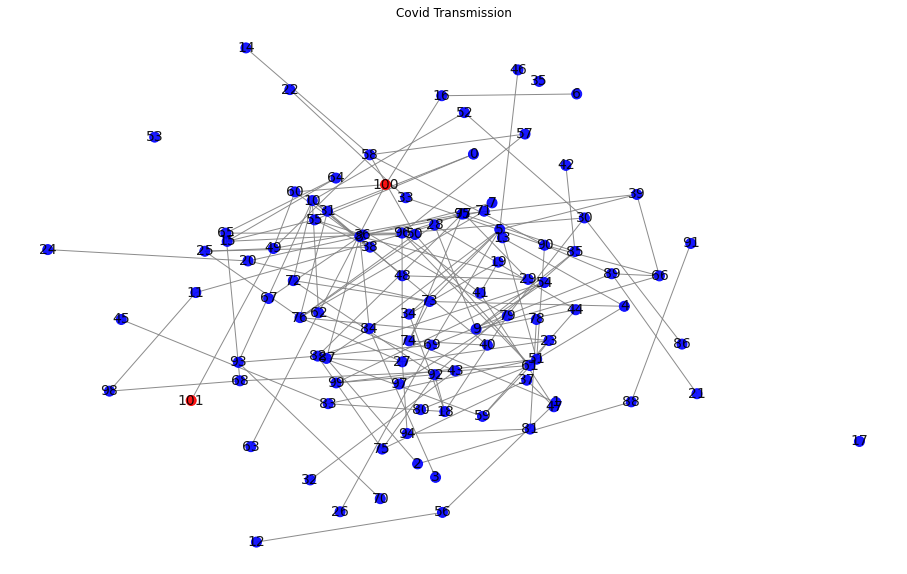

In [7]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
cmap = ListedColormap(["blue", "orange", "red",])

def plot_grid(model,fig,layout='spring',title=''):
    graph = model.G
    if layout == 'kamada-kawai':      
        pos = nx.kamada_kawai_layout(graph)  
    elif layout == 'circular':
        pos = nx.circular_layout(graph)
    else:
        pos = nx.spring_layout(graph, iterations=5, seed=8)  
    plt.clf()
    ax=fig.add_subplot()
    states = [int(i.state) for i in model.grid.get_all_cell_contents()]
    colors = [cmap(i) for i in states]

    nx.draw(graph, pos, node_size=100, edge_color='gray', node_color=colors, #with_labels=True,
            alpha=0.9,font_size=14,ax=ax,with_labels=True)
    ax.set_title(title)
    return
steps=10
fig,ax=plt.subplots(1,1,figsize=(16,10))

model = NetworkInfectionModel(100, ptrans=0.1)

model.step()
f=plot_grid(model,fig,layout='spring',title="Covid Transmission")

In [8]:
model.G.nodes

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101))

In [13]:
import panel as pn 
pn.extension()
def run_model(pop,  ptrans, degree, steps, delay, layout):

    model = NetworkInfectionModel(pop,Add=2,ptrans=ptrans, avg_node_degree=degree)

    fig1 = plt.Figure(figsize=(8,6))
    grid_pane.object = fig1
    fig2 = plt.Figure(figsize=(8,6))
    ax2=fig2.add_subplot(1,1,1,label='b')
    states_pane.object = fig2

    #step through the model and plot at each step
    for i in range(steps):
        model.step(i)
        plot_grid(model,fig1,title='step=%s' %i, layout=layout)        
        grid_pane.param.trigger('object')
        ax2.clear()
        plot_states(model,ax2)
        ax2.set_xlim(0,steps)        
        states_pane.param.trigger('object')    
        time.sleep(delay)
    plt.clf()
    

grid_pane    = pn.pane.Matplotlib()
states_pane  = pn.pane.Matplotlib()
go_btn       = pnw.Button(name='run',width=100,button_type='primary')
pop_input    = pnw.IntSlider(name='population',value=100,start=10,end=1000,step=10,width=100)
ptrans_input = pnw.FloatSlider(name='prob. trans',value=0.1,width=100)
degree_input = pnw.IntSlider(name='node degree',value=3,start=1,end=10,width=100)
steps_input  = pnw.IntSlider(name='steps',value=20,start=5,end=100,width=100)
delay_input  = pnw.FloatSlider(name='delay',value=.2,start=0,end=3,step=.2,width=100)
layout_input = pnw.Select(name='layout',options=['spring','circular','kamada-kawai'],width=100)
widgets      = pn.WidgetBox(go_btn,pop_input,steps_input,delay_input,layout_input)

def execute(event):
    #run the model with widget options
    run_model(pop_input.value,  ptrans_input.value, degree_input.value,steps_input.value, delay_input.value, layout_input.value)
go_btn.param.watch(execute, 'clicks')

pn.Row(pn.Column(widgets),grid_pane,states_pane,sizing_mode='stretch_width')

Row(sizing_mode='stretch_width')
    [0] Column
        [0] WidgetBox
            [0] Button(button_type='primary', name='run', width=100)
            [1] IntSlider(end=1000, name='population', start=10, step=10, value=100, value_throttled=100, width=100)
            [2] IntSlider(end=100, name='steps', start=5, value=20, value_throttled=20, width=100)
            [3] FloatSlider(end=3, name='delay', step=0.2, value=0.2, value_throttled=0.2, width=100)
            [4] Select(name='layout', options=['spring', 'circular', ...], value='spring', width=100)
    [1] Matplotlib(None)
    [2] Matplotlib(None)

In [10]:
import pandas as pd
def get_column_data(model):
    #pivot the model dataframe to get states count at each step
    agent_state = model.datacollector.get_agent_vars_dataframe()
    X = pd.pivot_table(agent_state.reset_index(),index='Step',columns='State',aggfunc=np.size,fill_value=0)    
    labels = ['Susceptible','Exposed','Infected']
    X.columns = labels[:len(X.columns)]
    return X
    
def plot_states(model,ax):    
    steps = model.schedule.steps
    X = get_column_data(model)
    X.plot(ax=ax,lw=3,alpha=0.8)
    return f
pop=200
steps=50
st=time.time()
model = NetworkInfectionModel(pop,ptrans=0.5)
for i in range(steps):
    model.step()
print("Running time:{}".format(time.time()-st))
agent_state = model.datacollector.get_agent_vars_dataframe()
print (get_column_data(model)[:50])

Running time:0.17953157424926758
      Susceptible  Exposed  Infected
Step                                
0             200        0         2
1             197        3         2
2             196        4         2
3             195        5         2
4             195        5         2
5             197        5         0
6             197        5         0
7             197        5         0
8             196        6         0
9             194        7         1
10            185       11         6
11            160       21        21
12             84       42        76
13             24       30       148
14             12       17       173
15             13       23       166
16             43       44       115
17             27       58       117
18             23       13       166
19             19       22       161
20             21       41       140
21             41       49       112
22             23       25       154
23             19       27       156
24   

No handles with labels found to put in legend.


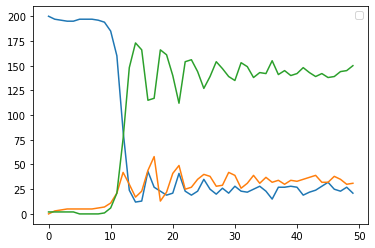

In [11]:
plt.plot(get_column_data(model))
plt.legend()

In [12]:
any(map(grid.is_cell_empty, neig))

NameError: name 'grid' is not defined